In [24]:
import numpy as np
from scipy.stats import norm, uniform

# Set random seed for reproducibility
np.random.seed(0)

# True distribution (used to generate data)
true_p = 0.55
true_mu1, true_sigma1 = 10, 1
true_mu2, true_sigma2 = 15, 1.5
true_dist = lambda x: true_p * norm.pdf(x, true_mu1, true_sigma1) + (1 - true_p) * norm.pdf(x, true_mu2, true_sigma2)

# Generate synthetic dataset from the true distribution
def generate_data(n_samples):
    labels = np.random.rand(n_samples) < true_p
    samples = np.where(labels,
                       norm.rvs(loc=true_mu1, scale=true_sigma1, size=n_samples),
                       norm.rvs(loc=true_mu2, scale=true_sigma2, size=n_samples))
    return samples

data = generate_data(200)

# Log-posterior (unnormalized) for the mixture model
def log_likelihood(params):
    p, mu1, sigma1, mu2, sigma2 = params
    if not (0 < p < 1 and sigma1 > 0 and sigma2 > 0):
        return -np.inf  # Invalid parameter values
    pdf_vals = p * norm.pdf(data, mu1, sigma1) + (1 - p) * norm.pdf(data, mu2, sigma2)
    if np.any(pdf_vals <= 0):
        return -np.inf
    return np.sum(np.log(pdf_vals))

# Proposal distribution (normal perturbation)
def propose(params, step_sizes):
    return np.array([
        np.clip(params[0] + np.random.normal(0, step_sizes[0]), 1e-3, 1 - 1e-3),  # p in (0,1)
        params[1] + np.random.normal(0, step_sizes[1]),                           # mu1
        np.clip(params[2] + np.random.normal(0, step_sizes[2]), 1e-2, None),      # sigma1 > 0
        params[3] + np.random.normal(0, step_sizes[3]),                           # mu2
        np.clip(params[4] + np.random.normal(0, step_sizes[4]), 1e-2, None),      # sigma2 > 0
    ])

# Metropolis-Hastings sampler
def metropolis_hastings(initial, num_samples=10000, step_sizes=None):
    if step_sizes is None:
        step_sizes = [0.02, 0.3, 0.1, 0.3, 0.1]

    current = np.array(initial)
    current_log_like = log_likelihood(current)
    samples = []
    
    for _ in range(num_samples):
        proposal = propose(current, step_sizes)
        proposal_log_like = log_likelihood(proposal)
        
        log_accept_ratio = proposal_log_like - current_log_like
        if np.log(np.random.rand()) < log_accept_ratio:
            current = proposal
            current_log_like = proposal_log_like
        
        samples.append(current.copy())
    
    return np.array(samples)

# Run MH and discard burn-in
initial_guess = [0.5, 9.0, 1.0, 16.0, 1.0]
samples = metropolis_hastings(initial_guess, num_samples=15000, step_sizes=[0.02, 0.3, 0.1, 0.3, 0.1])
samples = samples[5000:]  # burn-in

# Now you can use `samples` in the plotting code


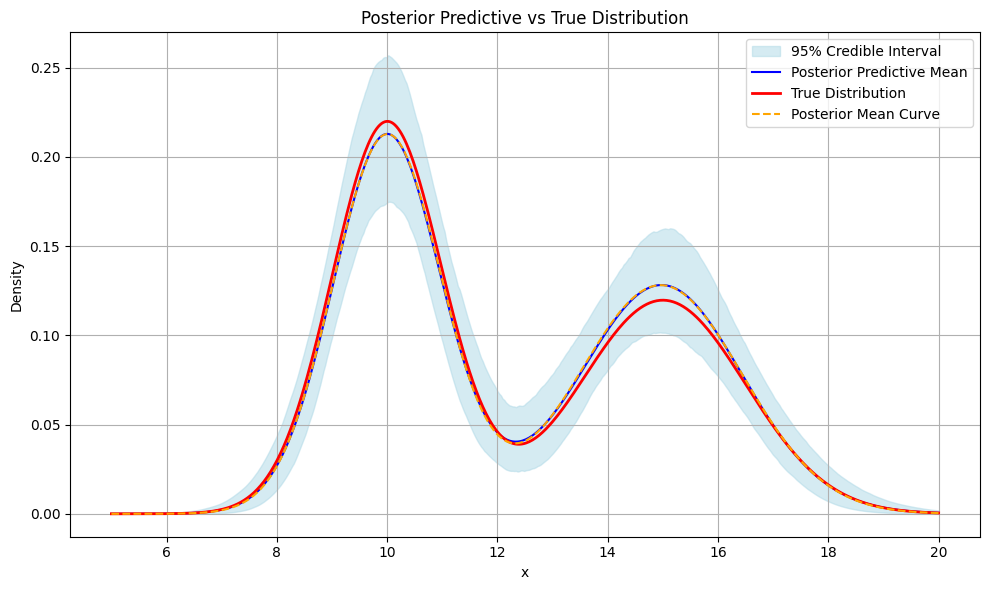

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Simulated posterior samples (replace with your own if needed)
# Each row: [p, mu1, sigma1, mu2, sigma2]
# Example: load or generate samples from MH
# samples = np.load("your_samples.npy")
# For this example we assume you already have `samples`
# And you also have `true_dist` from your model setup

# Step 1: Relabel samples to fix label-switching (ensure mu1 < mu2)
samples_sorted = samples.copy()
swap_idx = samples_sorted[:, 1] > samples_sorted[:, 3]  # mu1 > mu2
samples_sorted[swap_idx, 1], samples_sorted[swap_idx, 3] = samples_sorted[swap_idx, 3], samples_sorted[swap_idx, 1]
samples_sorted[swap_idx, 2], samples_sorted[swap_idx, 4] = samples_sorted[swap_idx, 4], samples_sorted[swap_idx, 2]

# Step 2: Compute posterior predictive distribution
x = np.linspace(5, 20, 500)
posterior_curves = (
    samples_sorted[:, 0, None] * norm.pdf(x, samples_sorted[:, 1, None], samples_sorted[:, 2, None]) +
    (1 - samples_sorted[:, 0, None]) * norm.pdf(x, samples_sorted[:, 3, None], samples_sorted[:, 4, None])
)
mean_pred = posterior_curves.mean(axis=0)
lower_95 = np.percentile(posterior_curves, 2.5, axis=0)
upper_95 = np.percentile(posterior_curves, 97.5, axis=0)

# Step 3: Plot posterior predictive with 95% credible interval
plt.figure(figsize=(10, 6))
plt.fill_between(x, lower_95, upper_95, color='lightblue', alpha=0.5, label='95% Credible Interval')
plt.plot(x, mean_pred, color='blue', label='Posterior Predictive Mean')

# Step 4: Plot true distribution
true_p = 0.55
true_y = true_p * norm.pdf(x, 10, 1) + (1 - true_p) * norm.pdf(x, 15, 1.5)
plt.plot(x, true_y, color='red', linewidth=2, label='True Distribution')

# Step 5: Plot posterior mean curve for reference
mean_params = samples_sorted.mean(axis=0)
p_hat, mu1_hat, sigma1_hat, mu2_hat, sigma2_hat = mean_params
mean_curve = p_hat * norm.pdf(x, mu1_hat, sigma1_hat) + (1 - p_hat) * norm.pdf(x, mu2_hat, sigma2_hat)
plt.plot(x, mean_curve, color='orange', linestyle='--', label='Posterior Mean Curve')

# Finalize plot
plt.title("Posterior Predictive vs True Distribution")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
